In [1]:
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox, OffsetImage
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

c:\caisplusplus\env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\caisplusplus\env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\caisplusplus\env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\caisplusplus\env\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1ty

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 2s 0us/step


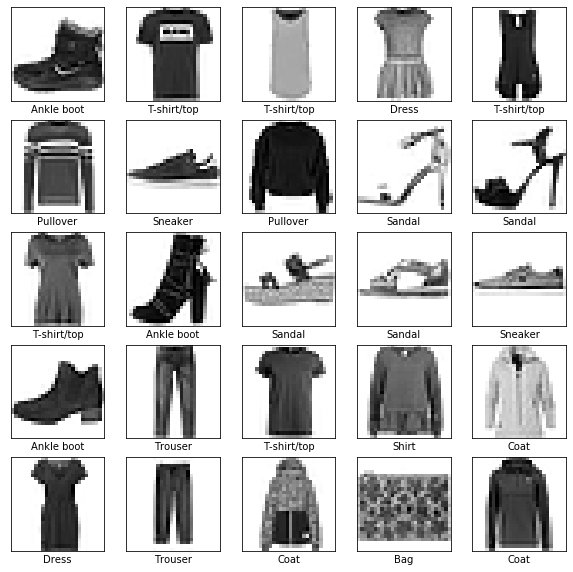

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [4]:
# Standardize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channel dimension of size 1
# (We only need 1 channel because the images are black and white)
train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)

In [5]:
# Define the encoder CNN using the tf.Keras functional API
# It should 2 conv/pool layers and a dense layer
def create_encoder(input_shape, encoding_dim):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, 3, padding="same", activation="relu")(inputs)
    pool1 = MaxPool2D()(conv1)
    conv2 = Conv2D(64, 3, padding="same", activation="relu")(pool1)
    pool2 = MaxPool2D()(conv2)
    flatten = Flatten()(pool2)
    dense = Dense(encoding_dim, activation="softmax")(flatten)
    
    encoder = Model(inputs, dense)
    encoder.summary()
    
    return encoder

In [6]:
# Define the decoder CNN using the tf.Keras functional API
# It should a reshape layer, 2 conv transpose layers, and a pixel-wise conv layer
def create_decoder(encoding_dim):
    if not sqrt(encoding_dim).is_integer():
        raise ValueError("Encoding dim must be a perfect square.")
    
    inputs = Input(shape=encoding_dim)
    reshape = Reshape((int(sqrt(encoding_dim)), int(sqrt(encoding_dim)), 1))(inputs)
    conv1 = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(reshape)
    conv2 = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(conv1)
    conv3 = Conv2D(1, 3, padding="same", activation="sigmoid")(conv2)
    
    decoder = Model(inputs, conv3)
    decoder.summary()
    
    return decoder

In [7]:
input_shape = train_images[0].shape
encoding_dim = 49 # Why did I pick 49?

In [8]:
# Instantiate the encoder and the decoder
encoder = create_encoder(input_shape, encoding_dim)
decoder = create_decoder(encoding_dim)

# Define the autoencoder architecture using the tf.Keras functional API
# Recall that it goes input -> encoder -> decoder
inputs = Input(shape=input_shape)
encoded = encoder(inputs)
decoded = decoder(encoded)

# Create and compile the autoencoder model
# Which loss function? (See slides)
autoencoder = Model(inputs, decoded)
autoencoder.summary()

autoencoder.compile(optimizer="adam", loss="mse")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________

In [9]:
# Fit the model for 250 epochs (make sure you're on the GPU)
autoencoder.fit(train_images, train_images, batch_size=256, epochs=250)

Epoch 1/250
60000/60000 [==============================] - 6s 98us/sample - loss: 0.0905
Epoch 2/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0222
Epoch 3/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0184
Epoch 4/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0174
Epoch 5/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0170
Epoch 6/250
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0167
Epoch 7/250
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0164
Epoch 8/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0162
Epoch 9/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0161
Epoch 10/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0160
Epoch 11/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0158
Epoch 12/250
60000/

60000/60000 [==============================] - 2s 37us/sample - loss: 0.0122
Epoch 93/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0122
Epoch 94/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0122
Epoch 95/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0122
Epoch 96/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0122
Epoch 97/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0121
Epoch 98/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0121
Epoch 99/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0121
Epoch 100/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0121
Epoch 101/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0121
Epoch 102/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0121
Epoch 103/250
60000/

60000/60000 [==============================] - 2s 36us/sample - loss: 0.0116
Epoch 183/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0116
Epoch 184/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0115
Epoch 185/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0116
Epoch 186/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0115
Epoch 187/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0116
Epoch 188/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0115
Epoch 189/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0115
Epoch 190/250
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0116
Epoch 191/250
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0115
Epoch 192/250
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0115
Epoch 193/250

In [10]:
# Evaluate the model on the test set
test_loss = autoencoder.evaluate(test_images, test_images, batch_size=256)

10000/10000 [==============================] - 0s 33us/sample - loss: 0.0117


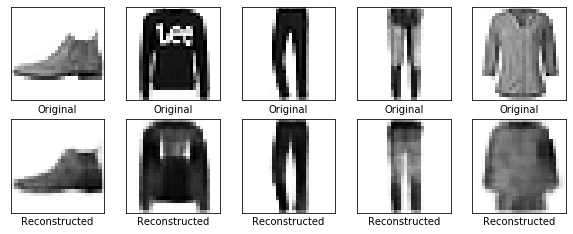

In [11]:
# Predict on 5 images from the test set
# Store the predictions in a variable called preds
visual = test_images[:5]
preds = autoencoder.predict(visual)

# This plots the original and reconstructed images
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel("Original")
for i in range(5):
    plt.subplot(5,5,i+6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel("Reconstructed")
plt.show()

In [12]:
# This function plots the latent space of the autoencoder
# Note that we isolate the encoder half of the autoencoder
# Also note that we are only plotting 2 dimensions of
# a multidimensional space.
def plot_latent(mode, count):
    idx = np.random.choice(len(test_images), count)
    inputs = test_images[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title("Autoencoder Latent Space")
    coords = encoder.predict(inputs)[:, :2]
    
    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = test_labels[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(class_names[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

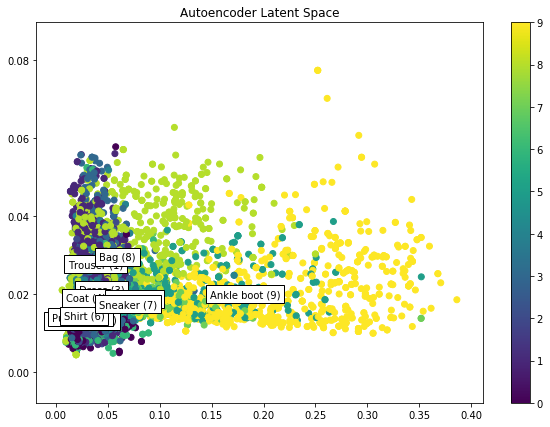

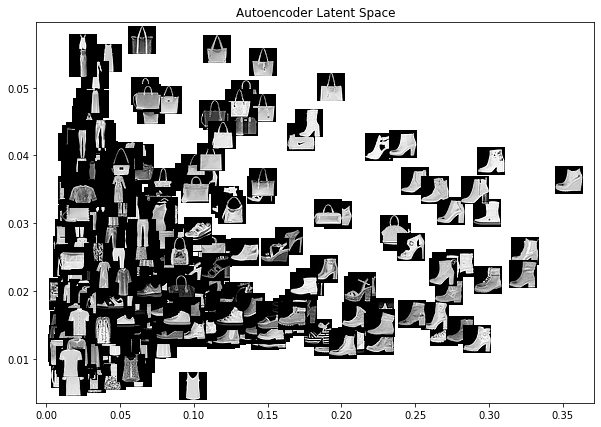

In [13]:
# Call the plot_latent function with different modes and counts
# What do you observe?
plot_latent("dots", 10000)
plot_latent("imgs", 1000)

In [ ]:
# Try varying the architecture to correspond with different dimensions of latent space
# What happens as the latent space becomes larger? Is there a "sweet spot"?
# In particular, try with a latent space dimension of 2 to obtain the most accurate visualization
# And try with a larger latent space dimension to obtain a more accurate prediction.
